In [221]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression as LR
%matplotlib inline

In [222]:
with h5py.File('data.h5') as f:
    mnist = f['mnist'].value
    natural_images = f['natural_images'].value

# mnist.shape - (n_images, x_px, y_px) - (60000, 18, 18)
# natural_images.shape - (n_images, x_px, y_px) - (292864, 16, 16)

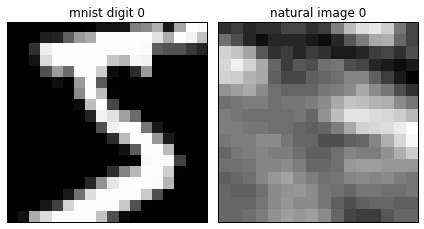

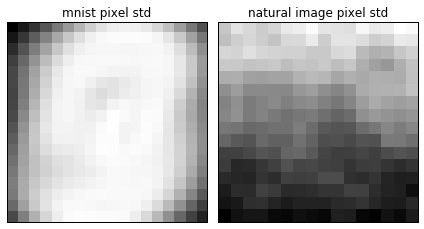

In [223]:
mnist_idx = 0
natural_images_idx = 0
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(mnist[mnist_idx], cmap='gray', interpolation='nearest')
ax1.set_title('mnist digit {}'.format(mnist_idx))
ax2.imshow(natural_images[natural_images_idx], cmap='gray', interpolation='nearest')
ax2.set_title('natural image {}'.format(natural_images_idx))
for ax in [ax1, ax2]:
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
f.tight_layout()

f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(mnist.std(axis=0), cmap='gray', interpolation='nearest')
ax1.set_title('mnist pixel std')
ax2.imshow(natural_images.std(axis=0), cmap='gray', interpolation='nearest')
ax2.set_title('natural image pixel std')
for ax in [ax1, ax2]:
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
f.tight_layout()

In [224]:
from sklearn.decomposition import PCA

In [236]:
data_type = 'natural images'
if data_type == 'natural images':
    data = natural_images
else:
    data = mnist
data = data.reshape(-1, data.shape[-1]**2)
data -= data.mean(axis=0)
data /= data.std(axis=0)
dim = data.shape[-1]

In [237]:
p = PCA()
data_pcs = p.fit_transform(data)
variance = p.explained_variance_

data_random = data.copy()
for ii in range(dim):
    order = np.random.permutation(data.shape[0])
    data_random[:, ii] = data_random[:, ii][order]
p2 = PCA()
p2.fit(data_random)
variance2 = p2.explained_variance_
data_pcs = p.transform(data)
data_random_pcs = p2.transform(data_random)

In [238]:
pcts = np.around(np.logspace(-2, 0, 15) * dim) / dim
num_keep = (pcts * dim).astype(int)
fourth = np.full((2, pcts.size, dim), np.nan)
for ii, keep in enumerate(num_keep):
    dpi = data_pcs[:, :keep]
    drpi = data_random_pcs[:, :keep]
    fourth[0, ii, :keep] = (dpi**2**2).mean(axis=0)/(dpi**2).mean(axis=0)**2
    fourth[1, ii, :keep] = (drpi**2**2).mean(axis=0)/(drpi**2).mean(axis=0)**2

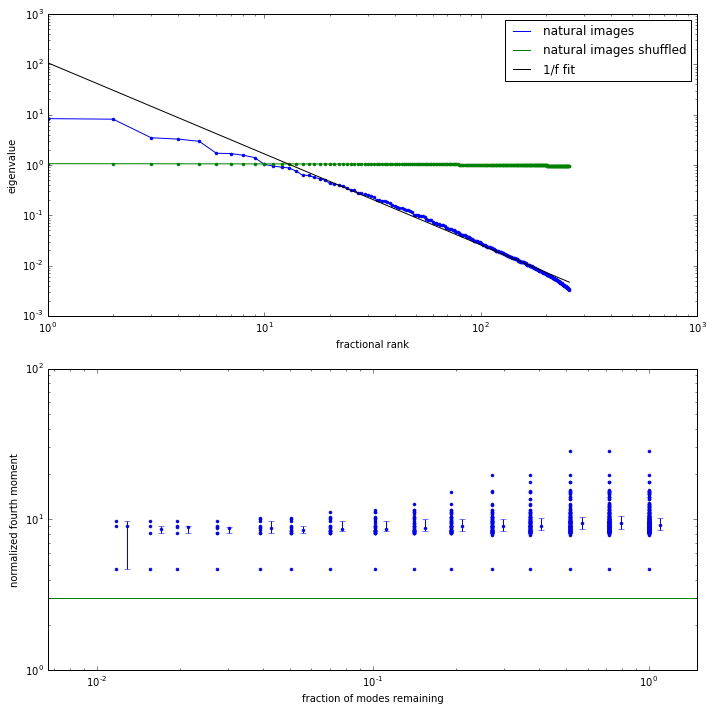

In [239]:
f, (ax1, ax2) = plt.subplots(2, figsize=(10, 10))
ax1.loglog(variance, 'b', label=data_type)
ax1.loglog(variance, 'b.')
ax1.loglog(variance2, 'g', label='{} shuffled'.format(data_type))
ax1.loglog(variance2, 'g.',)
ax1.set_ylabel('eigenvalue')
ax1.set_xlabel('fractional rank')

model = LR()
model.fit(np.atleast_2d(np.log(np.arange(dim)+1)).T, np.atleast_2d(np.log(variance)).T)
x = np.array([1., dim])
y = np.squeeze(np.exp(model.coef_ * np.log(x) + model.intercept_))
ax1.plot(x, y, 'k', label='1/f fit')

meds = np.zeros(pcts.size)
lows = np.zeros(pcts.size)
highs = np.zeros(pcts.size)

for ii, pct in enumerate(pcts):
    y = fourth[0, ii]
    y = y[np.logical_not(np.isnan(y))]
    ax2.loglog(np.tile(pct, y.size), y, 'b.', alpha=1.)
    ax2.axhline(3, drawstyle='--', color='green')
    meds[ii] = np.median(y)
    t5s5 = np.percentile(y, [25, 75], interpolation='nearest')
    lows[ii] = t5s5[0]
    highs[ii] = t5s5[1]
ax2.errorbar(pcts*1.1, meds, yerr=[meds-lows, highs-meds], fmt='b.')
ax2.set_xlim(1e-2/1.5, 1.5)
ax2.set_ylabel('normalized fourth moment')
ax2.set_xlabel('fraction of modes remaining')
ax1.legend()
f.tight_layout()
plt.savefig('{}.pdf'.format(data_type))